In [2]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
}))


In [3]:
options(reticulate.conda_binary = "software/anaconda3/bin/conda")
library(reticulate)
use_condaenv("R42")
source_python("mixture.py")
source("helper_functions_for_diffex.r")


Loading required package: limma


Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA




# Definitions etc

In [4]:
set.seed(1234)
options(digits = 2)
stats <- c()


In [5]:
if (!exists("papermill_run")) {
    prj_name <- "Screen1_66guides"
    # data_subdir_suffixes = "L1,L2,L3,L4"
    secondary_a_path <- "S1/analysis/secondary/"
    save_seurat_h5 <- "NO"
}


In [6]:
custom_theme <- theme(
  plot.title = element_text(size = 16, hjust = 0.5),
  legend.key.size = unit(0.7, "cm"),
  legend.text = element_text(size = 14)
)


### Load Seurat file

In [7]:
integrated_h5_path <- paste0(
    secondary_a_path,
    "integrated/seurat_objects/integrated_wo_guide_calls.h5seurat"
)
updated_integrated_h5_path <- paste0(
    secondary_a_path,
    "integrated/seurat_objects/integrated.h5seurat"
)
seurat_combined <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)


Validating h5Seurat file



Warning message:
"Adding a command log without an assay associated with it"


In [8]:
ncol(seurat_combined)


[1] 27142

Use only singlets (actually I didn't include the singlets in the integrated file, so this step is unnecessary)

In [9]:
seurat_combined <- subset(seurat_combined, subset = status == "singlet")


# Call all guides

Skipping guides with less than 50 counts


Running Lib_1 


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE6-2b 39 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_1 
Running Lib_2 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_2 
Running Lib_3 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_3 


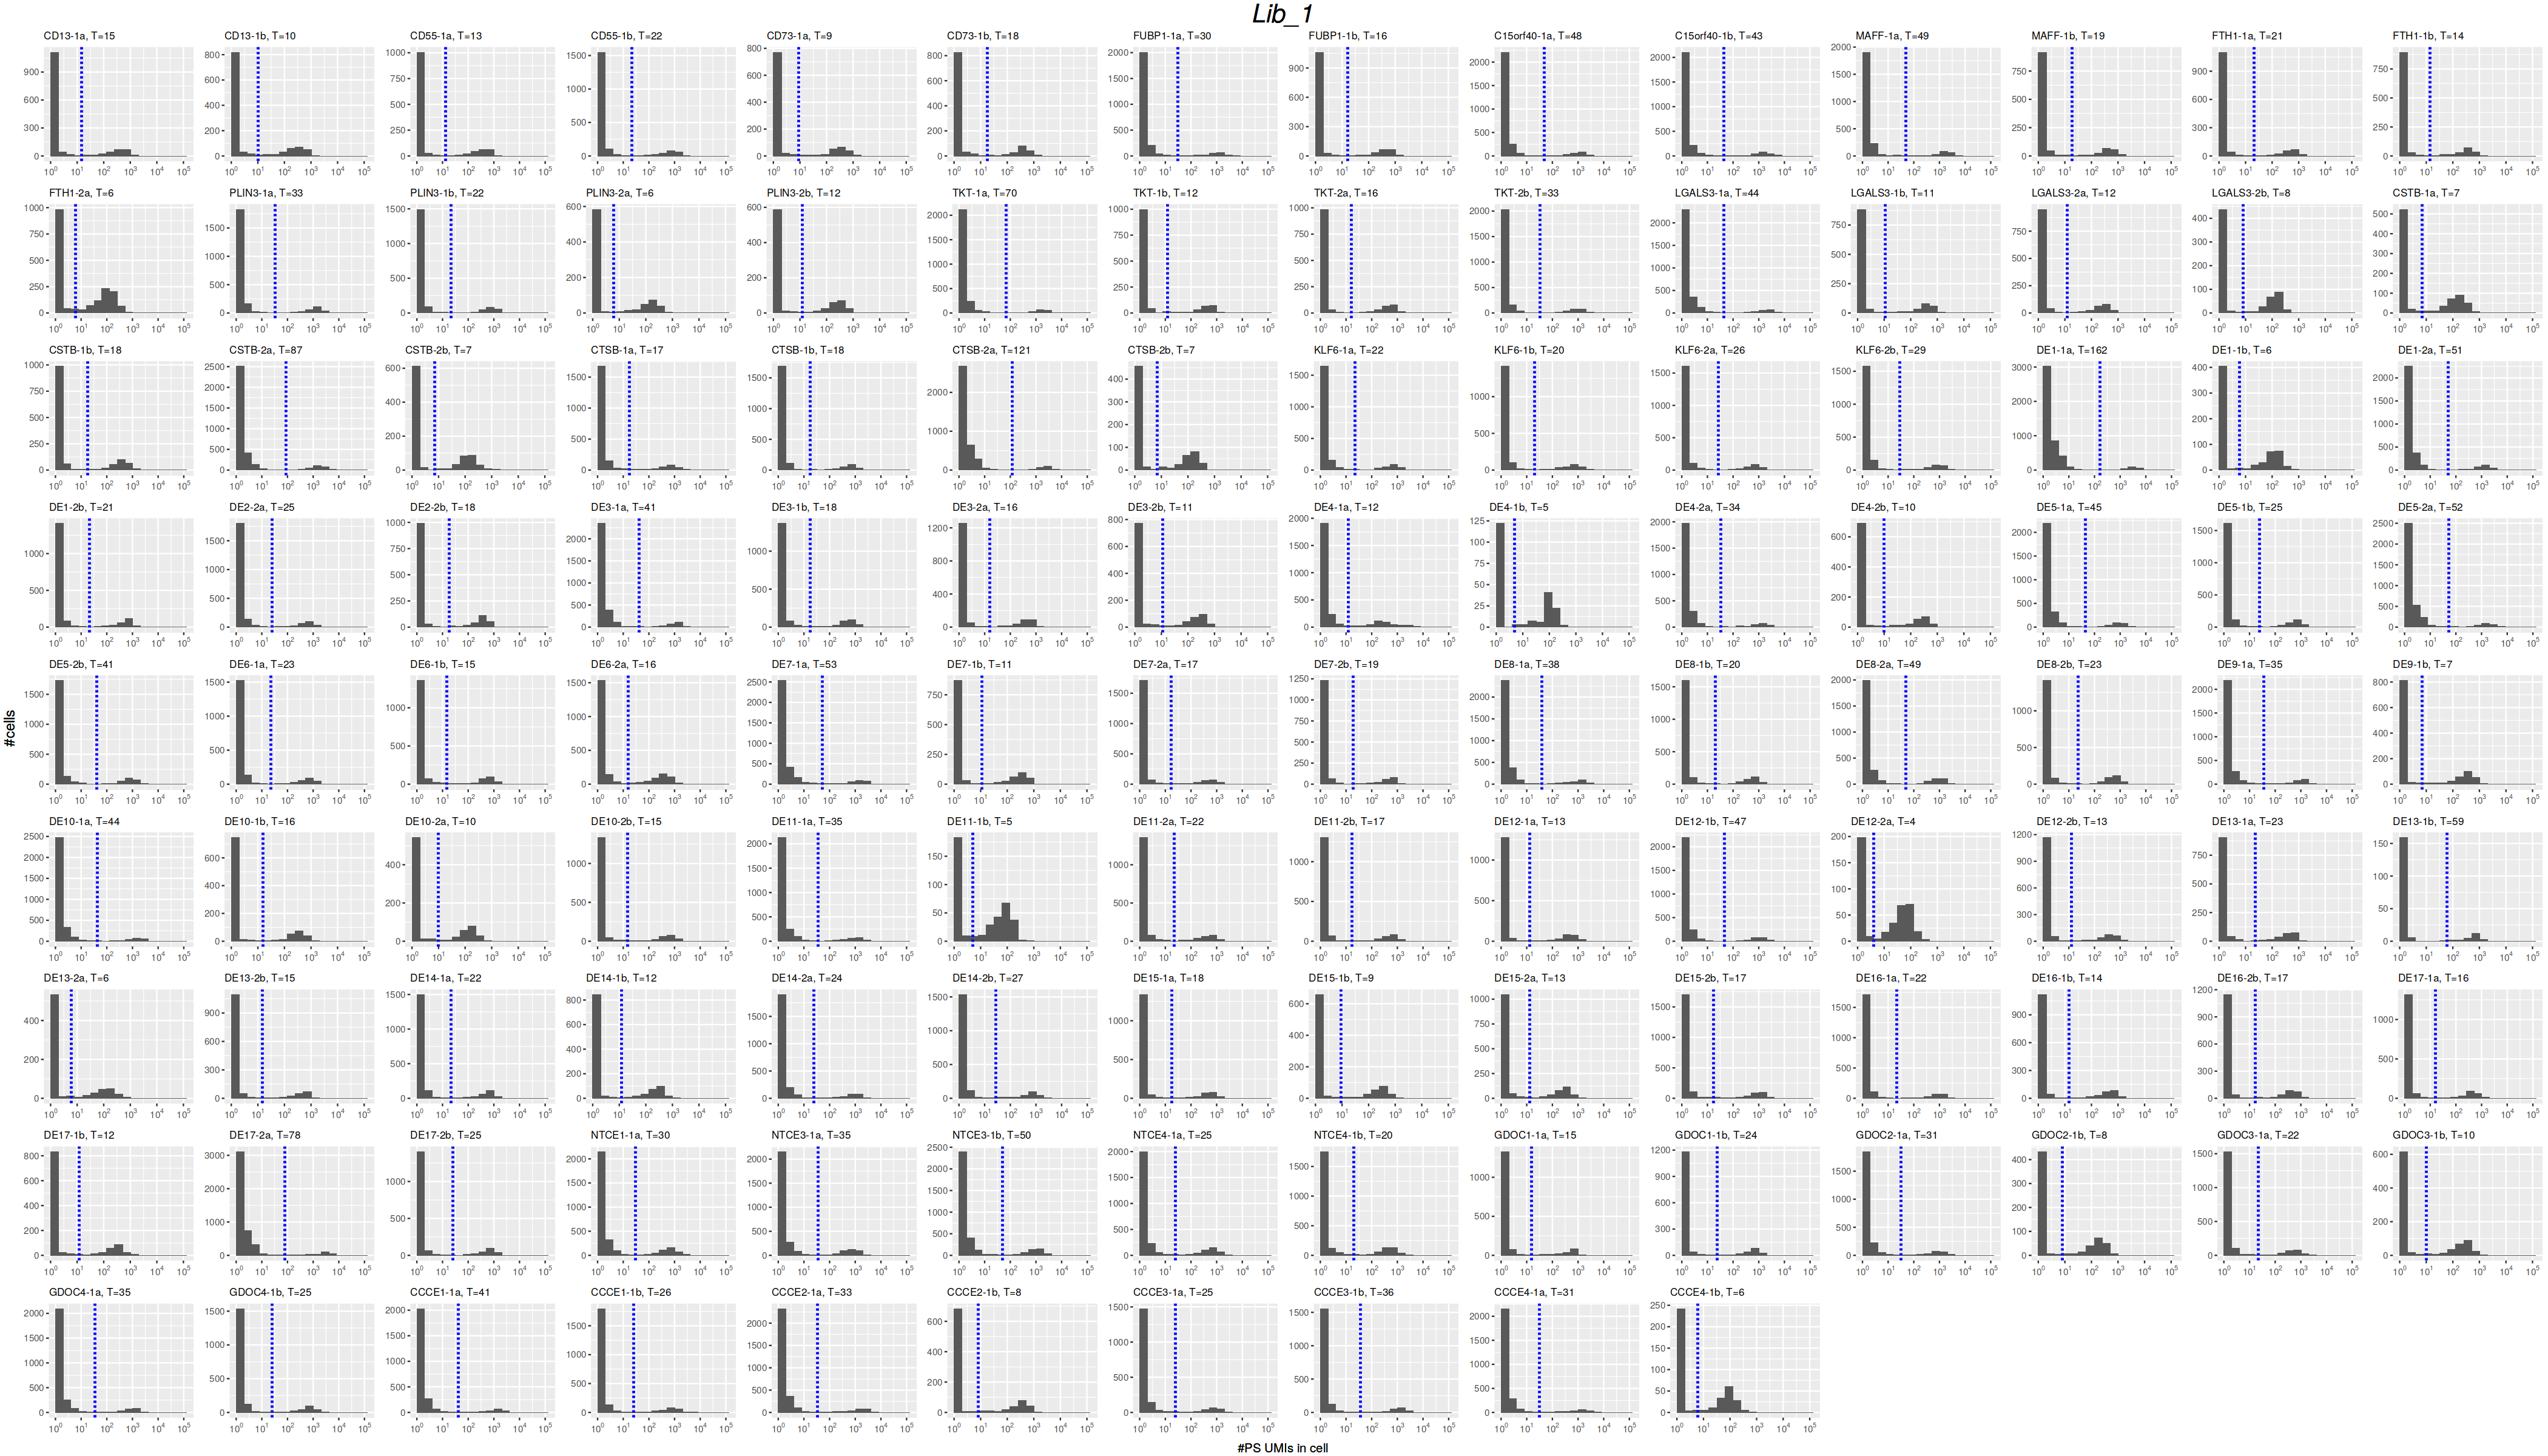

Running Lib_4 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 1 guides found
Skipping DE2-1b 1 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_4 


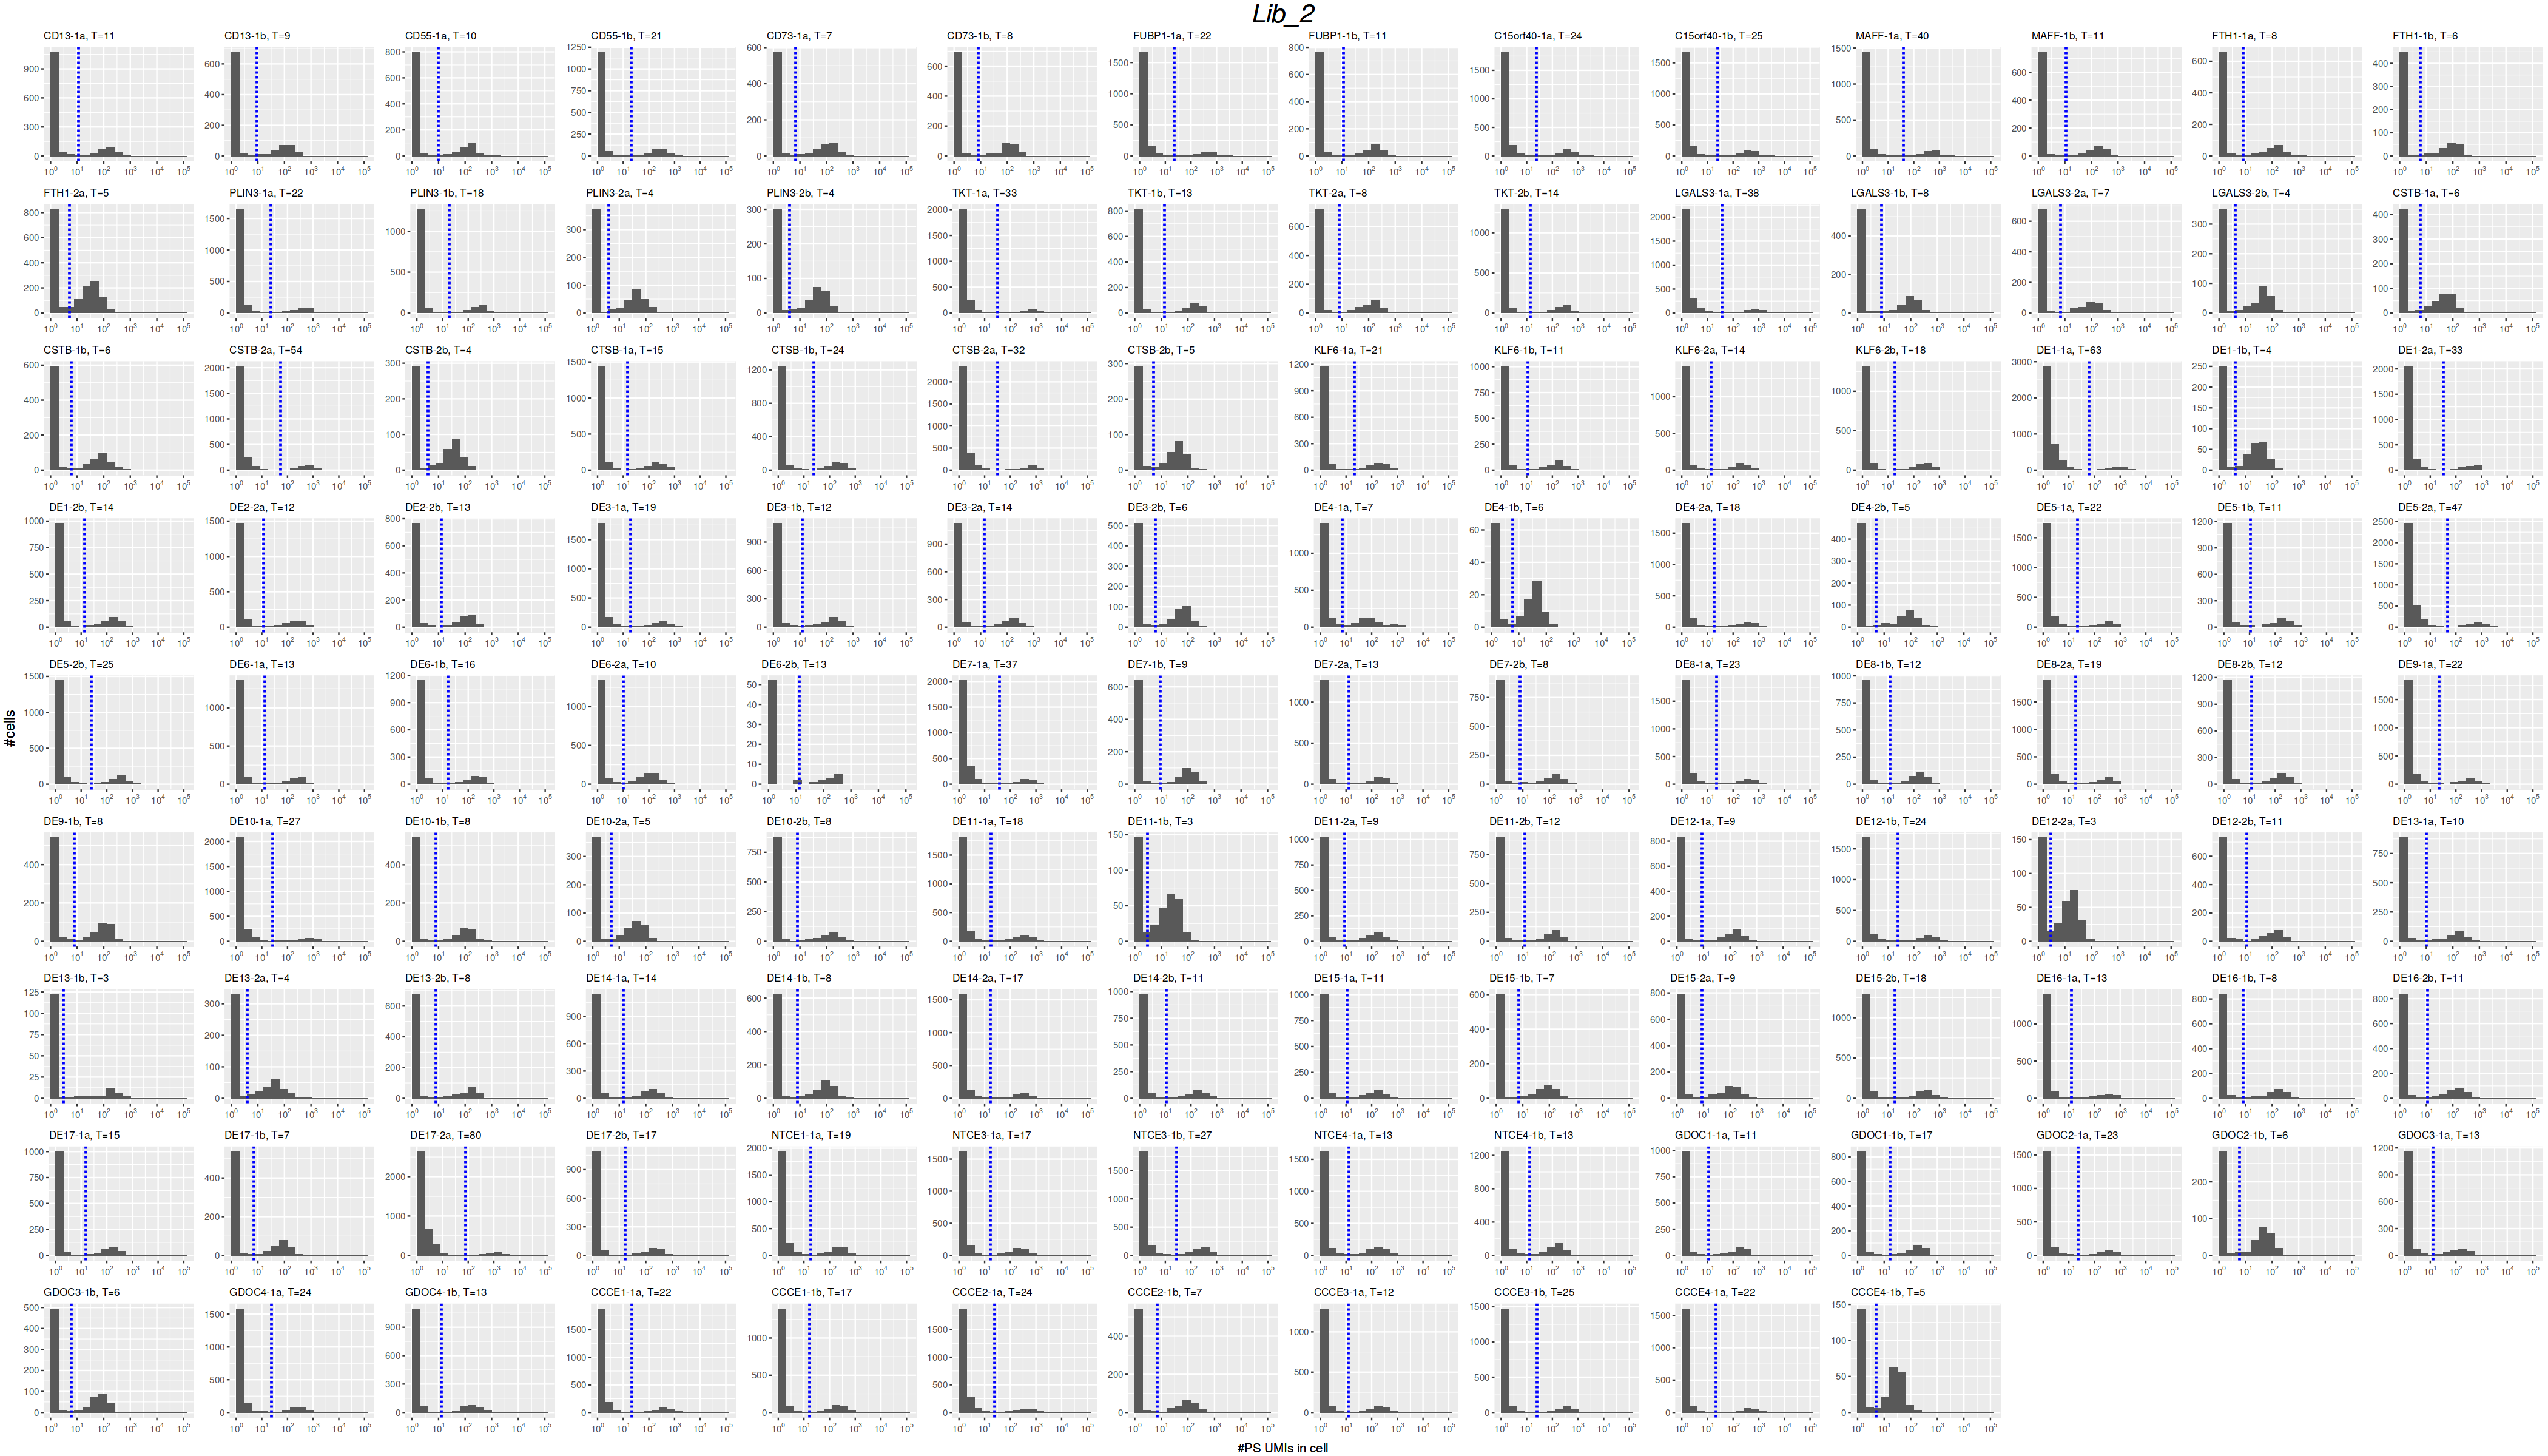

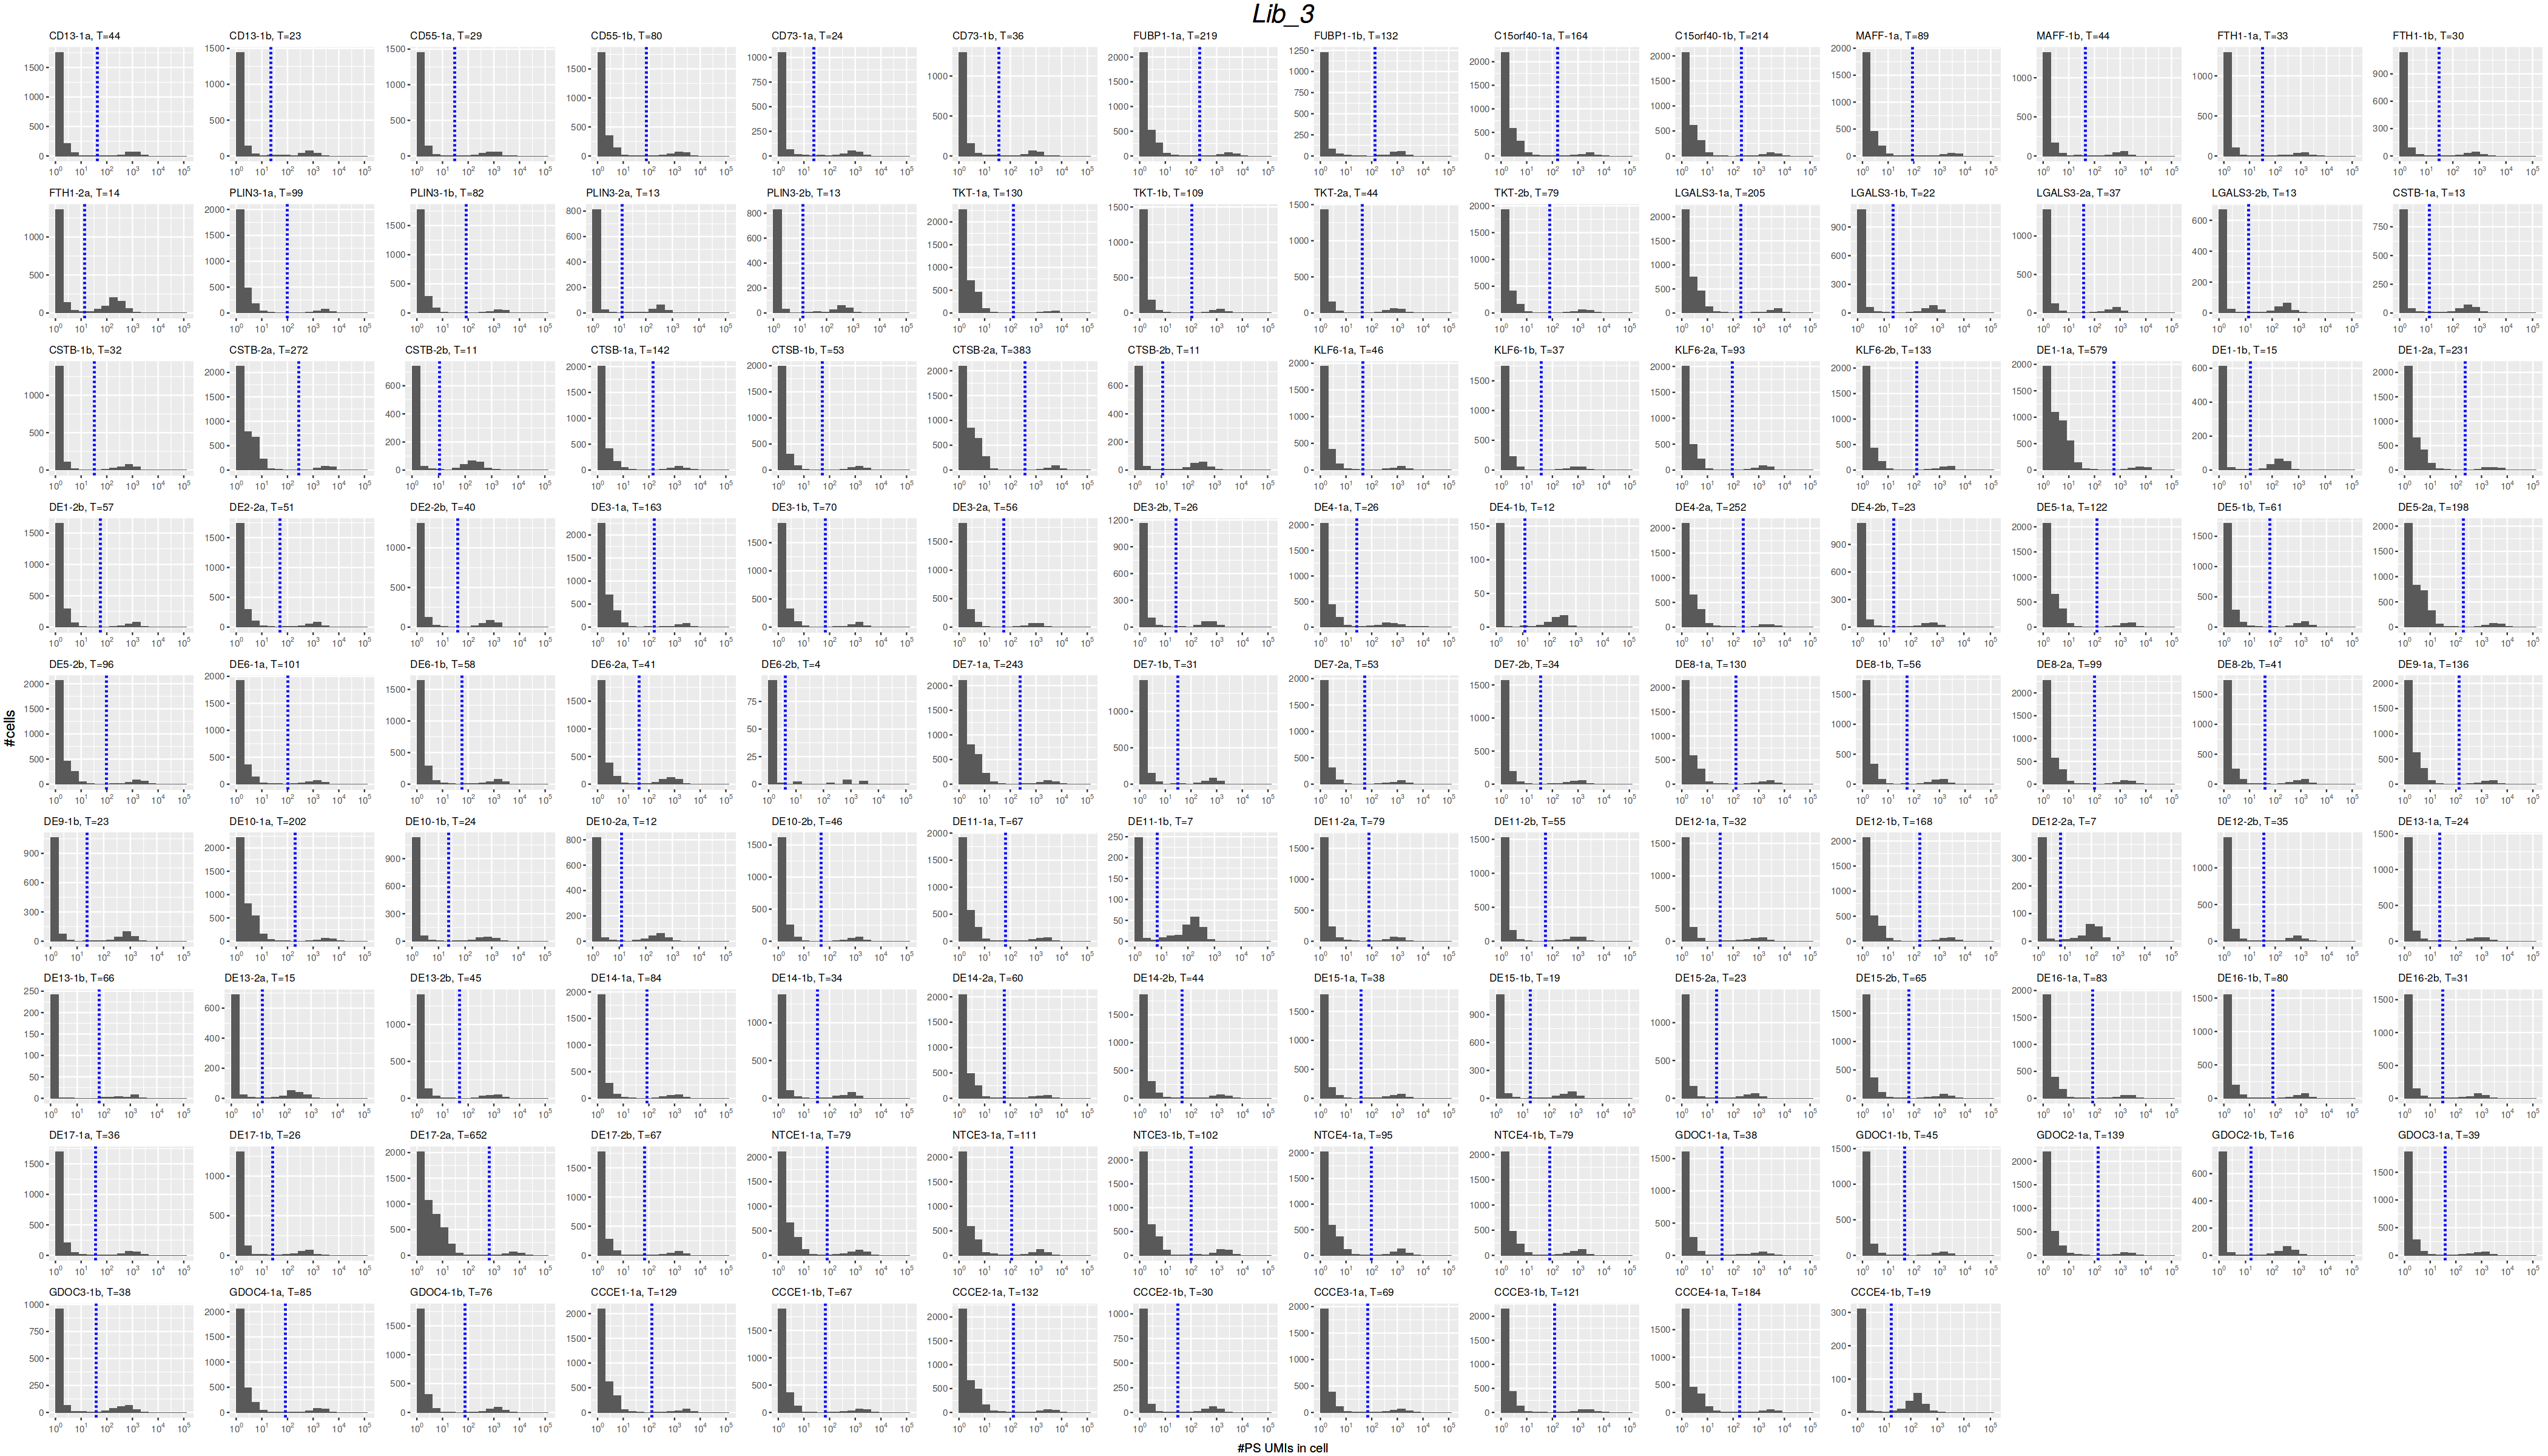

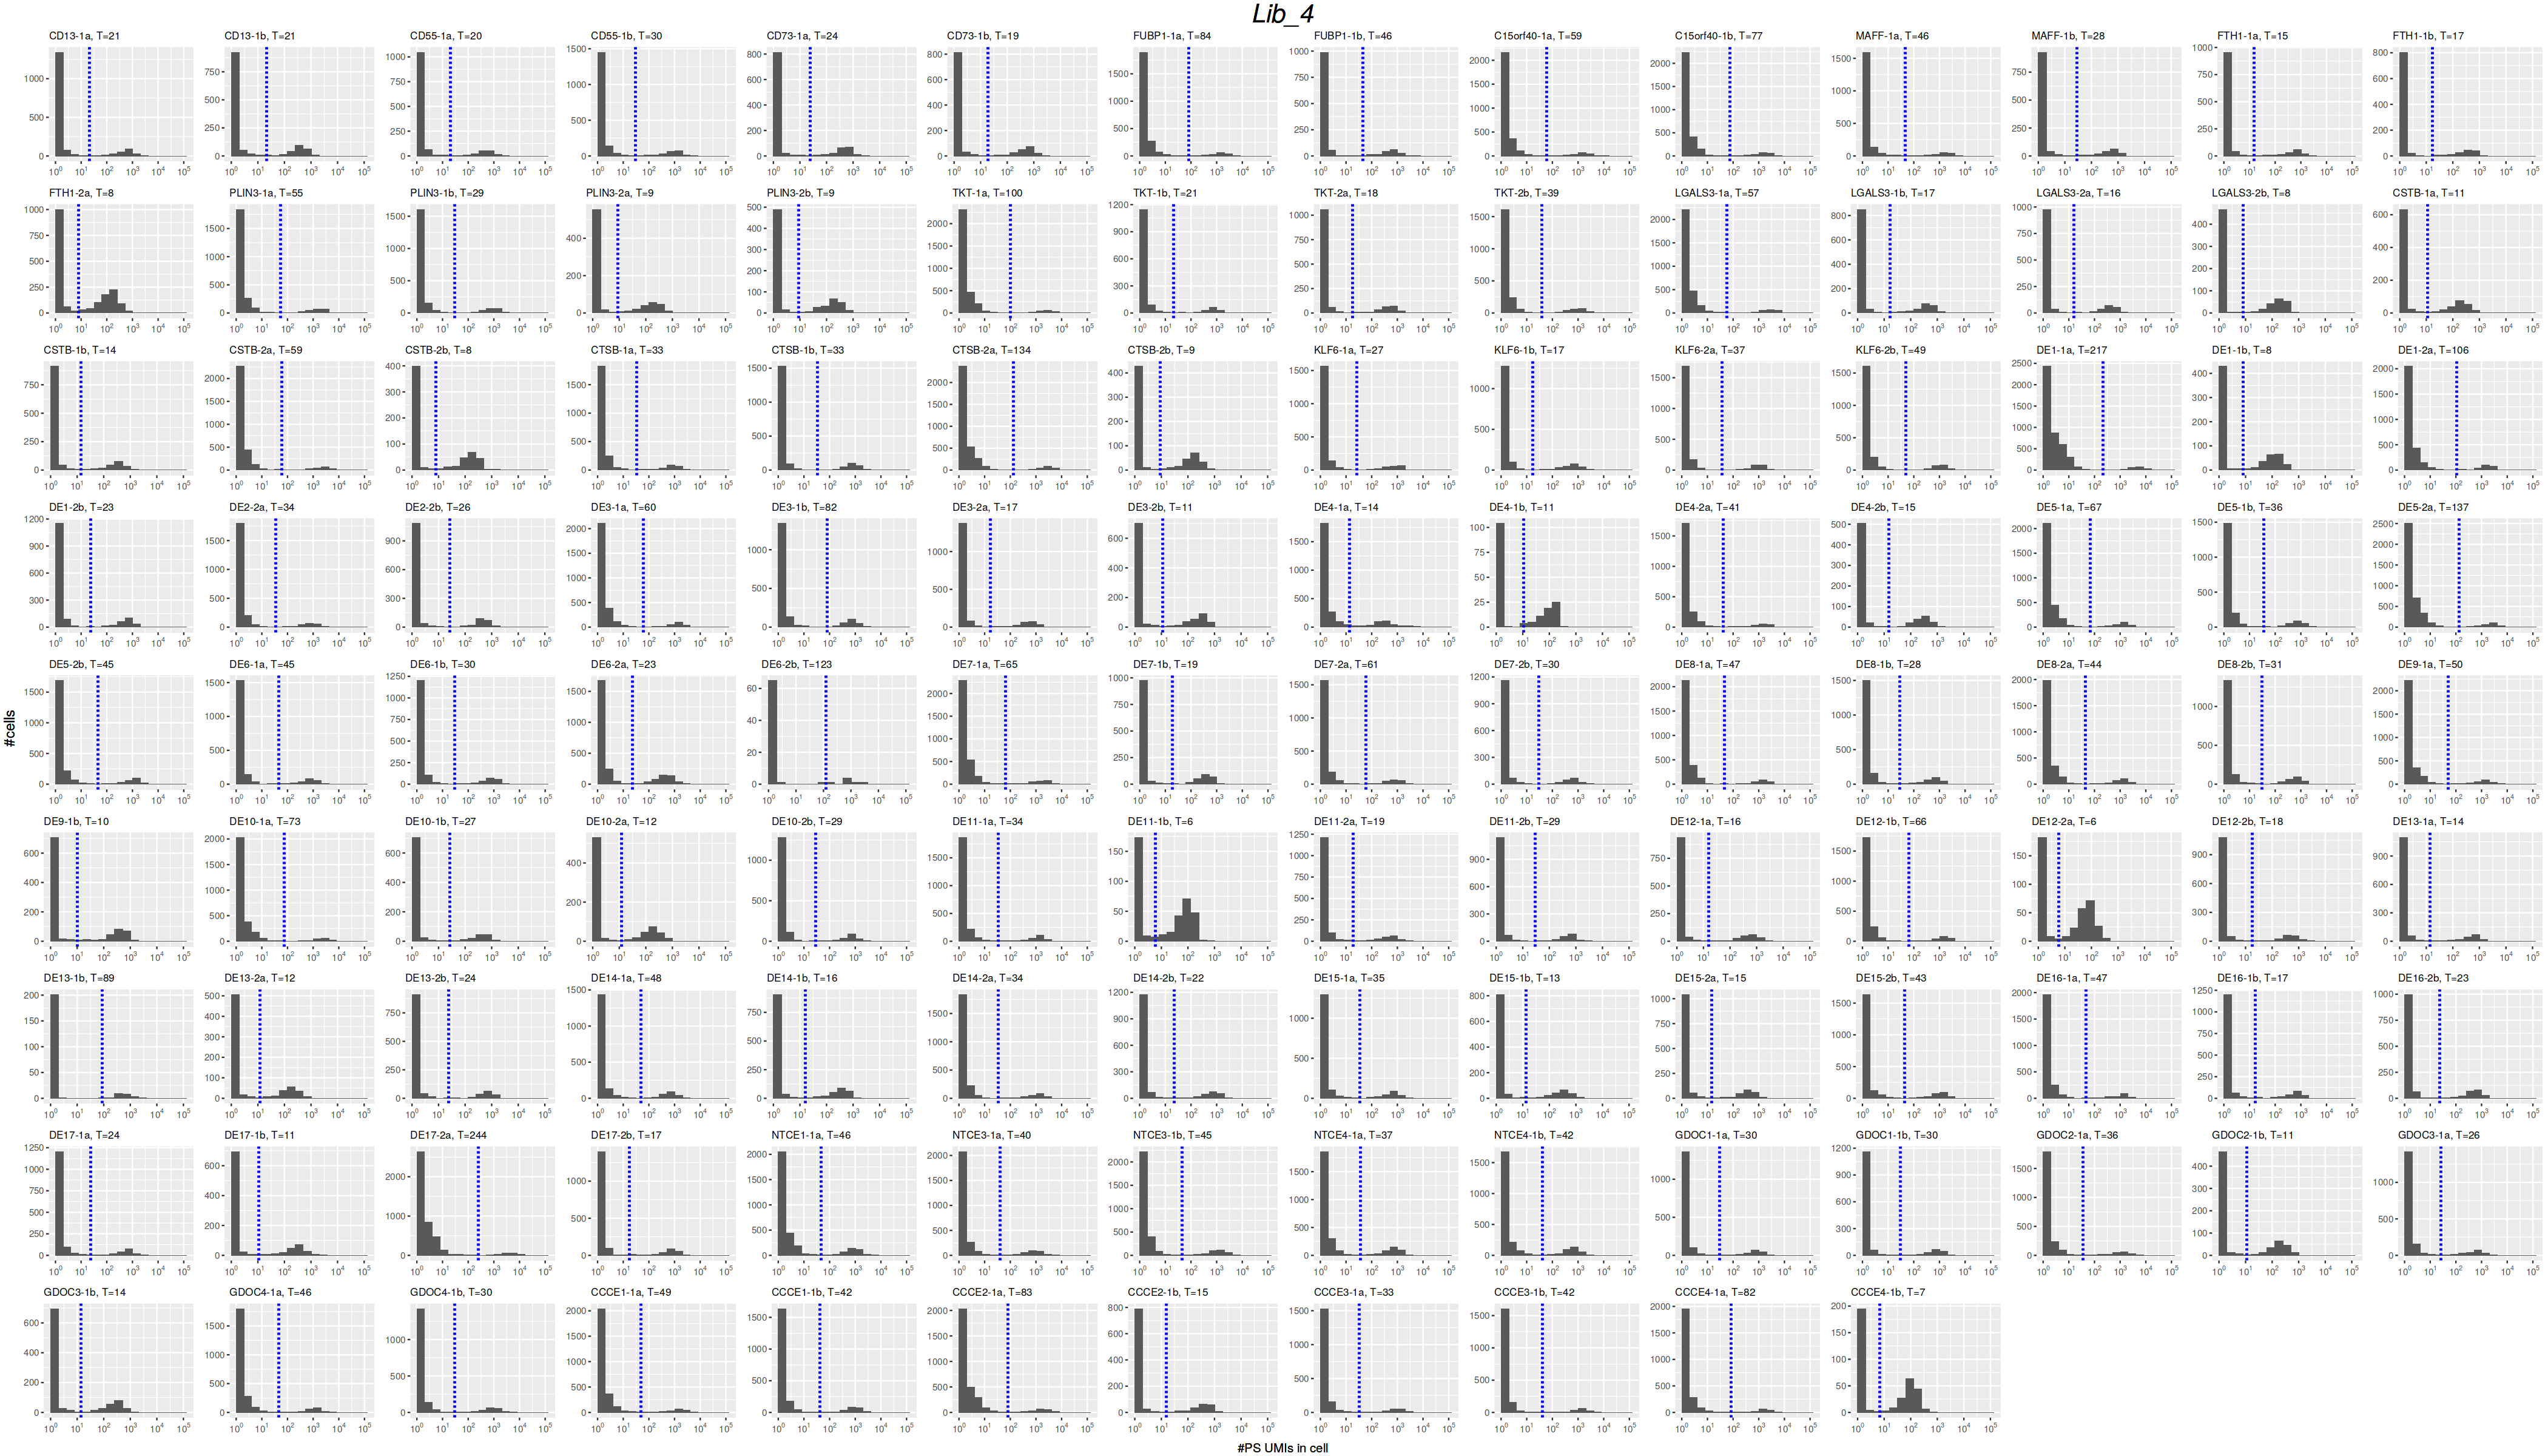

In [10]:
libraries <- unique(seurat_combined$library)
min_guide_count <- 50
df_thresholds <- data.frame(
    batch = character(0),
    guide = character(0),
    threshold = numeric(0)
)

cat(blue("Skipping guides with less than", min_guide_count, "counts\n"))
for (l in seq_along(libraries)) {
    # subset
    library_name <- libraries[[l]]
    cat(blue("Running", library_name, "\n"))
    seurat <- subset(seurat_combined, subset = library == library_name)

    DefaultAssay(seurat) <- "sgRNA"
    df_guide_counts <- as.data.frame(t(seurat[["sgRNA"]]@counts))
    rownames(df_guide_counts) <- NULL

    CUTOFF_PROB <- 0.5
    guides <- colnames(df_guide_counts)
    plots <- list()

    for (i in seq_along(guides)) {
        guide <- guides[[i]]
        y <- df_guide_counts[, guide]
        select_nonzeros <- y > 0
        y <- y[select_nonzeros]
        index <- nrow(df_thresholds) + 1
        if (length(y) <= min_guide_count) {
            cat("Skipping", guide, length(y), "guides found\n")
            df_thresholds[index, ] <- c(library_name, guide, NA)
            next
        }

        calls <- pgmix(y)
        df_calls <- as.data.frame(calls)
        df_calls["counts"] <- y
        colnames(df_calls) <- c("call", "prob", "count")
        options(repr.plot.width = 4, repr.plot.height = 4)
        head(df_calls)
        dim(df_calls)
        select_gaussian_assigned <- df_calls[, "prob"] > CUTOFF_PROB

        df_gauss <- df_calls[select_gaussian_assigned, ]
        dim(df_gauss)

        # head(df_gauss)
        threshold <- min(df_gauss$count)
        # cat("threshold=", threshold)
        filter_y <- y > 0
        y_filtered <- y[filter_y]
        df_y <- as.data.frame(y_filtered)
        head(df_y)

        options(repr.plot.width = 3.3, repr.plot.height = 2.4)
        bin_breaks <- c(1, 2, 2 * 2^(1:16))
        title <- paste0(guide, ", T=", threshold)

        ggp1 <- ggplot(df_y, aes(x = y_filtered)) + # Draw each column as histogram
            geom_histogram(breaks = bin_breaks) +
            scale_x_log10(
                labels = trans_format("log10", math_format(10^.x)),
                breaks = c(1, 10, 100, 1000, 10000, 100000)
            ) +
            labs(title = title, x = NULL, y = NULL) +
            geom_vline(
                xintercept = threshold,
                color = "blue",
                linetype = "dashed",
                size = 1
            ) +
            theme(plot.title = element_text(size = 10))

        plots <- append(plots, list(ggp1))
        # index = nrow(df_thresholds) + 1
        df_thresholds[index, ] <- c(library_name, guide, threshold)
    }
    cat(green("Completed", library_name, "\n"))
    flush.console()
    options(repr.plot.width = 35, repr.plot.height = 20)
    plt <- gridExtra::grid.arrange(
        grobs = plots,
        ncol = 14,
        bottom = textGrob("#PS UMIs in cell", gp = gpar(fontsize = 12)),
        left = textGrob("#cells", gp = gpar(fontsize = 14), rot = 90),
        top = textGrob(library_name, gp = gpar(fontsize = 25, font = 3))
    )
    grid::grid.draw(plt)
    pdf_path <- "S1/analysis/secondary/integrated/guide_distr/"
    ggsave(
        file = paste0(pdf_path, library_name, "_guide_distributions.pdf"),
        plt,
        width = 22,
        height = 17,
        dpi = 300
    )
}


# Write thresholds to file

In [11]:
thr_f_name <- paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
head(df_thresholds)

if (save_seurat_h5 == "YES") {
    write.table(df_thresholds, thr_f_name, sep = "\t", quote = F, row.names = F)
}


batch guide   threshold
1 Lib_1 CD13-1a 15       
2 Lib_1 CD13-1b 10       
3 Lib_1 CD55-1a 13       
4 Lib_1 CD55-1b 22       
5 Lib_1 CD73-1a 9        
6 Lib_1 CD73-1b 18

In [12]:
head(df_thresholds)


batch guide   threshold
1 Lib_1 CD13-1a 15       
2 Lib_1 CD13-1b 10       
3 Lib_1 CD55-1a 13       
4 Lib_1 CD55-1b 22       
5 Lib_1 CD73-1a 9        
6 Lib_1 CD73-1b 18

In [13]:
rownames(seurat_combined@misc$stats) <- seurat_combined@misc$stats$Library


In [14]:
nrow(seurat_combined@meta.data[seurat_combined@meta.data$library == "Lib_1", ])
seurat <- subset(seurat_combined, subset = library == "Lib_1")
nrow(seurat@meta.data)


[1] 7295

[1] 7295

# Update the Seurat object with Poission-Gaussian calls 

### Load thresholds

In [15]:
### Load THRESHOLDS.tsv
thr_f_name <- paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds <- read.table(thr_f_name, header = T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)
### Load guide df
df_guide <- read.table(
    "primary/S1_resources/66CRISPRi_ref_for_diffex.txt",
    sep = "\t",
    header = T,
    strip.white = T
)
head(df_guide)


gene     guide1      guide2      alias    subclass class     gene_or_rsid
1 CD13     CD13-1a     CD13-1b     ANPEP    tss      targeting ANPEP       
2 CD55     CD55-1a     CD55-1b     CD55     tss      targeting CD55        
3 CD73     CD73-1a     CD73-1b     NT5E     tss      targeting NT5E        
4 FUBP1    FUBP1-1a    FUBP1-1b    FUBP1    tss      targeting FUBP1       
5 C15orf40 C15orf40-1a C15orf40-1b C15orf40 tss      targeting C15orf40    
6 MAFF     MAFF-1a     MAFF-1b     MAFF     tss      targeting MAFF        
  label       diffexed_gene
1 Control TSS ANPEP        
2 Control TSS CD55         
3 Control TSS NT5E         
4 Control TSS FUBP1        
5 Control TSS C15orf40     
6 Control TSS MAFF

### Get the list of pertubed cells for each guide

In [16]:
perturbed_cells_by_guide <- get_perturbed_cells(seurat_combined, df_thresholds)


In [17]:
df_calls <- enframe(perturbed_cells_by_guide) %>% unnest(2)
df_calls <- as.data.frame(df_calls)
df_calls$guide <- as.character(df_calls$name)
df_calls$cell <- as.character(df_calls$value)
df_calls$name <- NULL
df_calls$value <- NULL
df_calls$plasmid <- sub(".$", "", df_calls$guide)


In [18]:
df_calls_wide <- df_calls %>%
    group_by(cell) %>%
    summarise(
        guide_calls = paste(unique(guide), collapse = "|"),
        plasmid_calls = paste(unique(plasmid), collapse = "|")
    )


In [19]:
df_calls_wide$n_guides <- str_count(df_calls_wide$guide_calls, "\\|") + 1
df_calls_wide$n_plasmids <- str_count(df_calls_wide$plasmid_calls, "\\|") + 1
df_calls_wide <- as.data.frame(df_calls_wide)
rownames(df_calls_wide) <- df_calls_wide$cell
df_calls_wide$cell <- NULL


In [20]:
head(df_calls_wide, 2)


guide_calls                          
AAACCCAAGAGCAGCT-1_1 FUBP1-1a|DE6-2a|DE8-1a|DE8-1b|DE15-2b
AAACCCAAGAGGTCAC-1_3 DE14-2b|NTCE1-1a|GDOC4-1a            
                     plasmid_calls              n_guides n_plasmids
AAACCCAAGAGCAGCT-1_1 FUBP1-1|DE6-2|DE8-1|DE15-2 5        4         
AAACCCAAGAGGTCAC-1_3 DE14-2|NTCE1-1|GDOC4-1     3        3

### Update the Seurat object with Poisson-Gaussian guide calls

Update the Seurat object

In [21]:
seurat_backup <- seurat_combined
# seurat_combined = seurat_backup


In [22]:
cols2rename <- c(
    "PS_call",
    "construct_call",
    "target_call",
    "nCalled_Constructs",
    "nPS_calls",
    "nCalled_sgRNA_UMIs"
)
df_dummy <- seurat_combined@meta.data
for (i in 1:length(cols2rename)) {
    colname <- cols2rename[i]
    names(df_dummy)[names(df_dummy) == colname] <- paste0("cellranger_", colname)
}


#### Merge calls with the Seurat object

In [23]:
df_dummy <- merge(df_dummy, df_calls_wide, by = 0, all.x = T)
rownames(df_dummy) <- df_dummy$Row.names
df_dummy$Row.names <- NULL
original_row_names <- rownames(seurat_combined@meta.data)
seurat_combined@meta.data <- df_dummy[original_row_names, ]


In [24]:
select_na <- is.na(seurat_combined$n_plasmids)
seurat_combined$n_plasmids[select_na] <- 0
seurat_combined$n_guides[select_na] <- 0


In [25]:
nrow(seurat_backup@meta.data)
nrow(seurat_combined@meta.data)
nrow(df_dummy)


[1] 27142

[1] 27142

[1] 27142

In [26]:
is.na(seurat_combined@meta.data[5, ]$guide_calls)


[1] TRUE

How many cells with no calls?

In [27]:
sum(seurat_combined$n_plasmids == 0)


[1] 6381

In [28]:
sum(rownames(seurat_combined) != rownames(seurat_backup))


[1] 0

In [29]:
nrow(df_calls_wide)
length(Cells(seurat_combined))


[1] 20761

[1] 27142

No-call cells are really not in df_calls_wide?

In [30]:
no_call_cells = rownames(
    seurat_combined@meta.data[seurat_combined$n_plasmids == 0, ]
)
intersect(rownames(df_calls_wide), no_call_cells)


character(0)

### Add guide-called cell counts to the Misc slot

In [31]:
call_counts <- c()
for (lib in rownames(seurat_combined@misc$stats)) {
    print(lib)
    seurat <- subset(seurat_combined, subset = library == lib)
    n_cells_w_a_plasmid_call <- sum(seurat$n_plasmids > 0)
    call_counts <- c(call_counts, n_cells_w_a_plasmid_call)
}


[1] "Lib_1"
[1] "Lib_2"
[1] "Lib_3"
[1] "Lib_4"


In [32]:
df_stats <- seurat_combined@misc$stats
stats_out_path <- paste0(secondary_a_path, "/stats/")
stats_fname <- paste0(stats_out_path, "ALL_STATS.tsv")
dir.create(stats_out_path, showWarnings = FALSE)
write.table(
    df_stats,
    file = stats_fname,
    quote = FALSE,
    sep = "\t",
    col.names = NA
)


In [33]:
stats_fname


[1] "/home/vsevim/prj/1012-ckd/S1/analysis/secondary//stats/ALL_STATS.tsv"

### Write thresholds and guides into misc

In [34]:
rownames(df_thresholds) <- df_thresholds$guide
seurat_combined@misc$thresholds <- df_thresholds
seurat_combined@misc$guides <- df_guide


In [35]:
head(seurat_combined, 5)


nCount_RNA nFeature_RNA nCount_sgRNA nFeature_sgRNA
AAACCCAAGAGCAGCT-1_1 25185      5887         3237         19            
AAACCCAAGCTTAAGA-1_1 43958      7411         2844         31            
AAACCCAAGGCTGTAG-1_1 73018      9094         1908         22            
AAACCCAAGGTTTACC-1_1 63652      8614         2088         20            
AAACCCAAGTGATCGG-1_1 34135      6635            7          7            
                     nCount_SCT nFeature_SCT orig.ident       library
AAACCCAAGAGCAGCT-1_1 24864      5840         Screen1_66guides Lib_1  
AAACCCAAGCTTAAGA-1_1 25774      6580         Screen1_66guides Lib_1  
AAACCCAAGGCTGTAG-1_1 24680      5745         Screen1_66guides Lib_1  
AAACCCAAGGTTTACC-1_1 25085      5994         Screen1_66guides Lib_1  
AAACCCAAGTGATCGG-1_1 25531      6506         Screen1_66guides Lib_1  
                     percent.mt status  donor dCas9 SCT_snn_res.0.5
AAACCCAAGAGCAGCT-1_1  6.7       singlet 3      20   1              
AAACCCAAGCTTAAGA-1_1  9.0       singlet 0      55   2              
AAACCCAAGGCTGTAG-1_1 14.0       singlet 0     181   2              
AAACCCAAGGTTTACC-1_1  6.2       singlet 2      58   0              
AAACCCAAGTGATCGG-1_1 15.5       singlet 2       1   6              
                     seurat_clusters guide_calls                          
AAACCCAAGAGCAGCT-1_1 1               FUBP1-1a|DE6-2a|DE8-1a|DE8-1b|DE15-2b
AAACCCAAGCTTAAGA-1_1 2               CD13-1a|CD13-1b|DE3-2a|DE3-2b        
AAACCCAAGGCTGTAG-1_1 2               TKT-1a|TKT-1b                        
AAACCCAAGGTTTACC-1_1 0               DE9-1a|DE9-1b|DE11-1a                
AAACCCAAGTGATCGG-1_1 6               NA                                   
                     plasmid_calls              n_guides n_plasmids
AAACCCAAGAGCAGCT-1_1 FUBP1-1|DE6-2|DE8-1|DE15-2 5        4         
AAACCCAAGCTTAAGA-1_1 CD13-1|DE3-2               4        2         
AAACCCAAGGCTGTAG-1_1 TKT-1                      2        1         
AAACCCAAGGTTTACC-1_1 DE9-1|DE11-1               3        2         
AAACCCAAGTGATCGG-1_1 NA                         0        0

In [36]:
is.na(seurat_combined@meta.data[5, ]$plasmid_calls)


[1] TRUE

### Save the updated Seurat object

In [37]:
if (save_seurat_h5 == "YES") {
    SaveH5Seurat(seurat_combined,
        updated_integrated_h5_path,
        overwrite = T,
        verbose = F
    )
}


# Visualizations using the PG guide-called data

### Constructs per cell distribution

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 3 rows containing missing values (`geom_bar()`)."


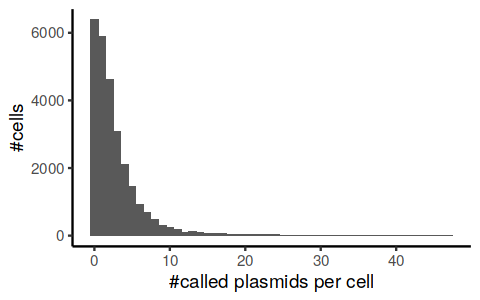

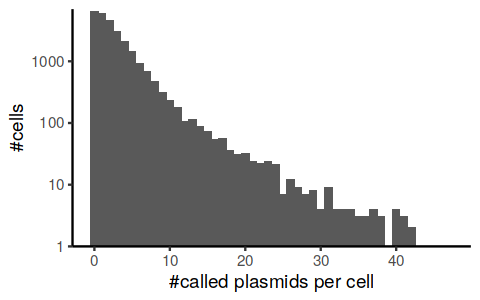

In [38]:
df_calls_all <- seurat_combined@meta.data[, c("n_plasmids", "n_guides")]

p5 <- ggplot(df_calls_all, aes(x = n_plasmids)) +
    geom_histogram(binwidth = 1) +
    labs(x = "#called plasmids per cell") +
    labs(y = "#cells") +
    theme_classic()

p6 <- ggplot(df_calls_all, aes(x = n_plasmids)) +
    geom_histogram(binwidth = 1) +
    scale_y_log10(limits = c(1, 7000), expand = c(0, 0)) +
    labs(x = "#called plasmids per cell") +
    labs(y = "#cells") +
    theme_classic()

options(repr.plot.width = 4, repr.plot.height = 2.5)
p5
p6


In [39]:
mean(df_calls_all$n_plasmids[df_calls_all$n_plasmids > 0])
mean(df_calls_all$n_plasmids)
nrow(df_calls_all)


[1] 3.6

[1] 2.8

[1] 27142

### Plot cells per plasmid distribution

In [40]:
plasmid_calls <- seurat_combined@meta.data$plasmid_calls
plasmid_calls <- str_split(paste0(plasmid_calls, collapse = "|"), "\\|")
df_dummy <- as.data.frame(table(plasmid_calls))
df_dummy$plasmid_calls <- as.character(df_dummy$plasmid_calls)
df_dummy[df_dummy$plasmid_calls == "NA", "plasmid_calls"] <- " No Plasmid"


In [41]:
head(df_dummy, 20)


plasmid_calls Freq
1  C15orf40-1    1076
2  CCCE1-1       1176
3  CCCE2-1       1073
4  CCCE3-1        965
5  CCCE4-1        804
6  CD13-1        1161
7  CD55-1        1081
8  CD73-1        1020
9  CSTB-1        1254
10 CSTB-2        1216
11 CTSB-1        1249
12 CTSB-2        1097
13 DE1-1         1114
14 DE1-2         1238
15 DE10-1         953
16 DE10-2        1059
17 DE11-1        1220
18 DE11-2        1106
19 DE12-1        1119
20 DE12-2        1075

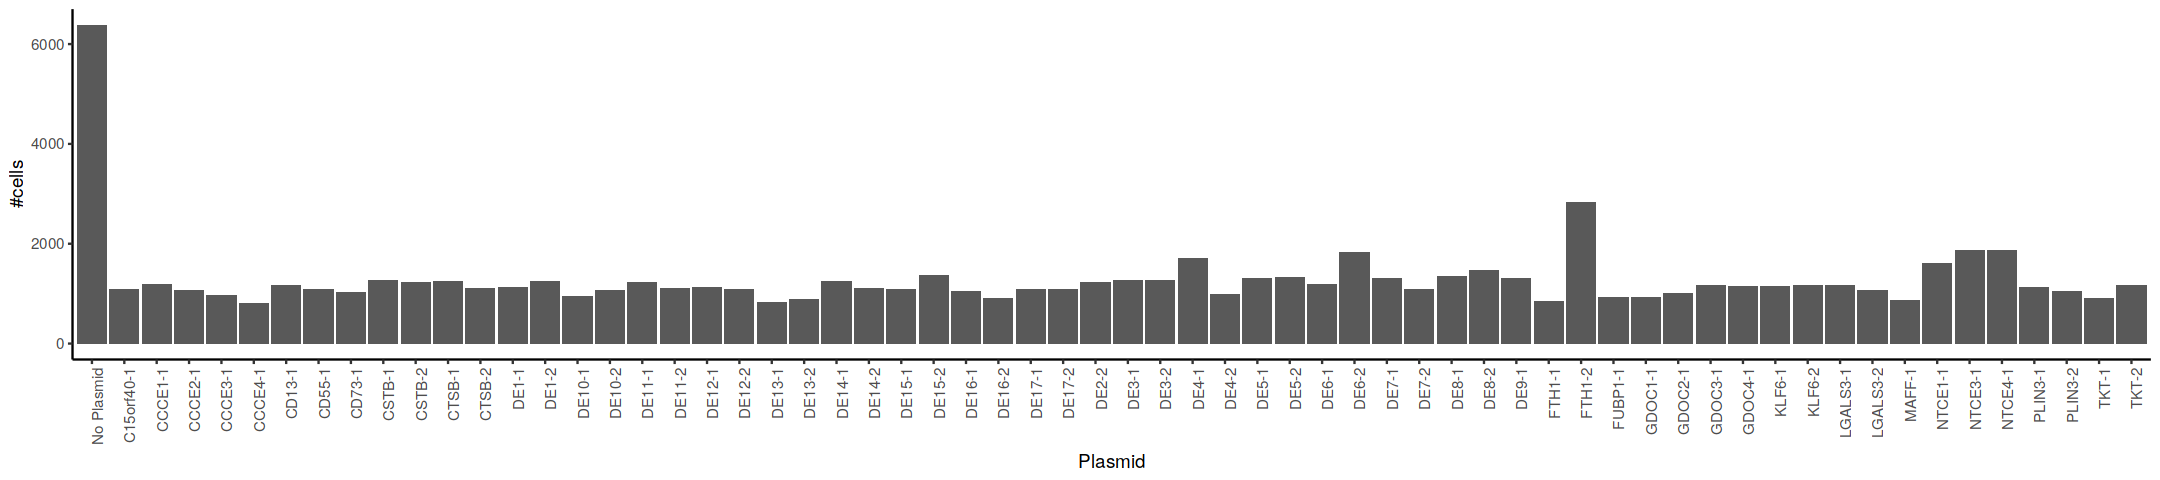

In [42]:
p6 <- ggplot(df_dummy, aes(x = plasmid_calls, y = Freq)) +
    geom_bar(stat = "identity") +
    labs(x = "Plasmid") +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1)) +
    labs(y = "#cells")

options(repr.plot.width = 18, repr.plot.height = 4)
p6


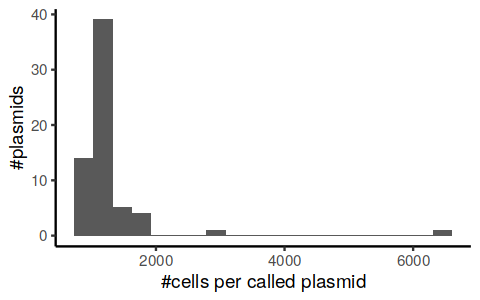

In [43]:
options(repr.plot.width = 4, repr.plot.height = 2.5)
ggplot(df_dummy, aes(Freq)) +
    geom_histogram(bins = 20) +
    labs(x = "#cells per called plasmid") +
    labs(y = "#plasmids") +
    theme_classic()


#### Eliminate no-call cells and plot again

In [44]:
df_dummy <- df_dummy[df_dummy$plasmid_calls != " No Plasmid", ]


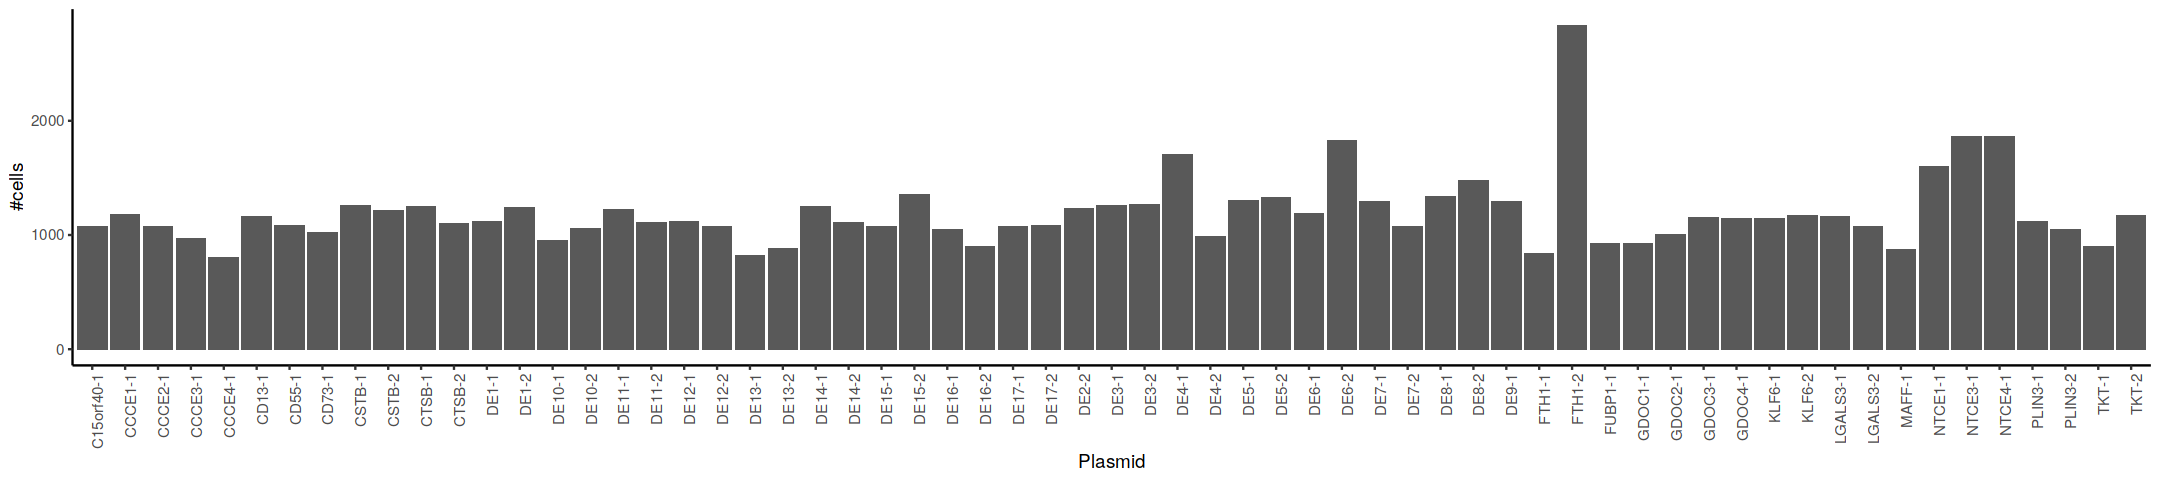

In [45]:
p6 <- ggplot(df_dummy, aes(x = plasmid_calls, y = Freq)) +
    geom_bar(stat = "identity") +
    labs(x = "Plasmid") +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1)) +
    labs(y = "#cells")

options(repr.plot.width = 18, repr.plot.height = 4)
p6


Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


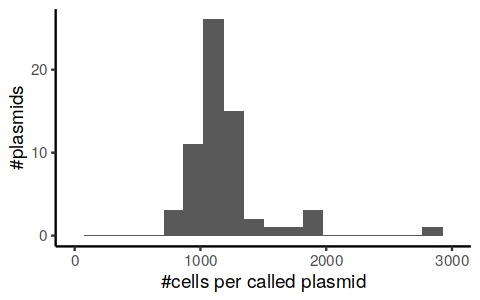

In [46]:
options(repr.plot.width = 4, repr.plot.height = 2.5)
ggplot(df_dummy, aes(Freq)) +
    geom_histogram(bins = 20) +
    labs(x = "#cells per called plasmid") +
    labs(y = "#plasmids") +
    xlim(-1, 3000) +
    theme_classic()


In [47]:
length(Cells(subset(seurat_combined, subset = library == "Lib_2")))


[1] 7527

# Stats

In [48]:
df_stats <- seurat_combined@misc$stats
df_stats


Cells_after_QC_filtering Cells_recovered
Lib_1 8015                     9183           
Lib_2 8564                     9445           
Lib_3 6300                     7109           
Lib_4 7196                     8016           
      Cells_with_sgRNA_count_less_than_100 Doublets_in_filtered_cells
Lib_1 1786                                  719                      
Lib_2 2221                                 1032                      
Lib_3 1130                                  512                      
Lib_4 1572                                  663                      
      Genes_recovered Library Max_mito_perc_threshold Max_n_RNA_threshold
Lib_1 31871           Lib_1   17                      98499              
Lib_2 30914           Lib_2   18                      52966              
Lib_3 29596           Lib_3   17                      34268              
Lib_4 31426           Lib_4   17                      79628              
      Max_n_genes_threshold Min_mito_perc_threshold Min_n_RNA_threshold
Lib_1 12196                 3                       -22205             
Lib_2  9739                 3                       -10548             
Lib_3  8026                 3                        -5042             
Lib_4 11196                 3                       -14470             
      Min_n_genes_threshold Protospacers_in_assay Screen          
Lib_1 2000                  132                   Screen1_66guides
Lib_2 2000                  132                   Screen1_66guides
Lib_3 2000                  132                   Screen1_66guides
Lib_4 2000                  132                   Screen1_66guides
      Singlets_after_filtering Singlets_perc_after_filtering
Lib_1 7295                     0.91                         
Lib_2 7527                     0.88                         
Lib_3 5787                     0.92                         
Lib_4 6533                     0.91                         
      Total_doublets_before_filtering
Lib_1  918                           
Lib_2 1168                           
Lib_3  617                           
Lib_4  793

# dCas9 - sgRNA count correlation

Warning message:
"Removed 180 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 4926 rows containing missing values (`geom_point()`)."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"


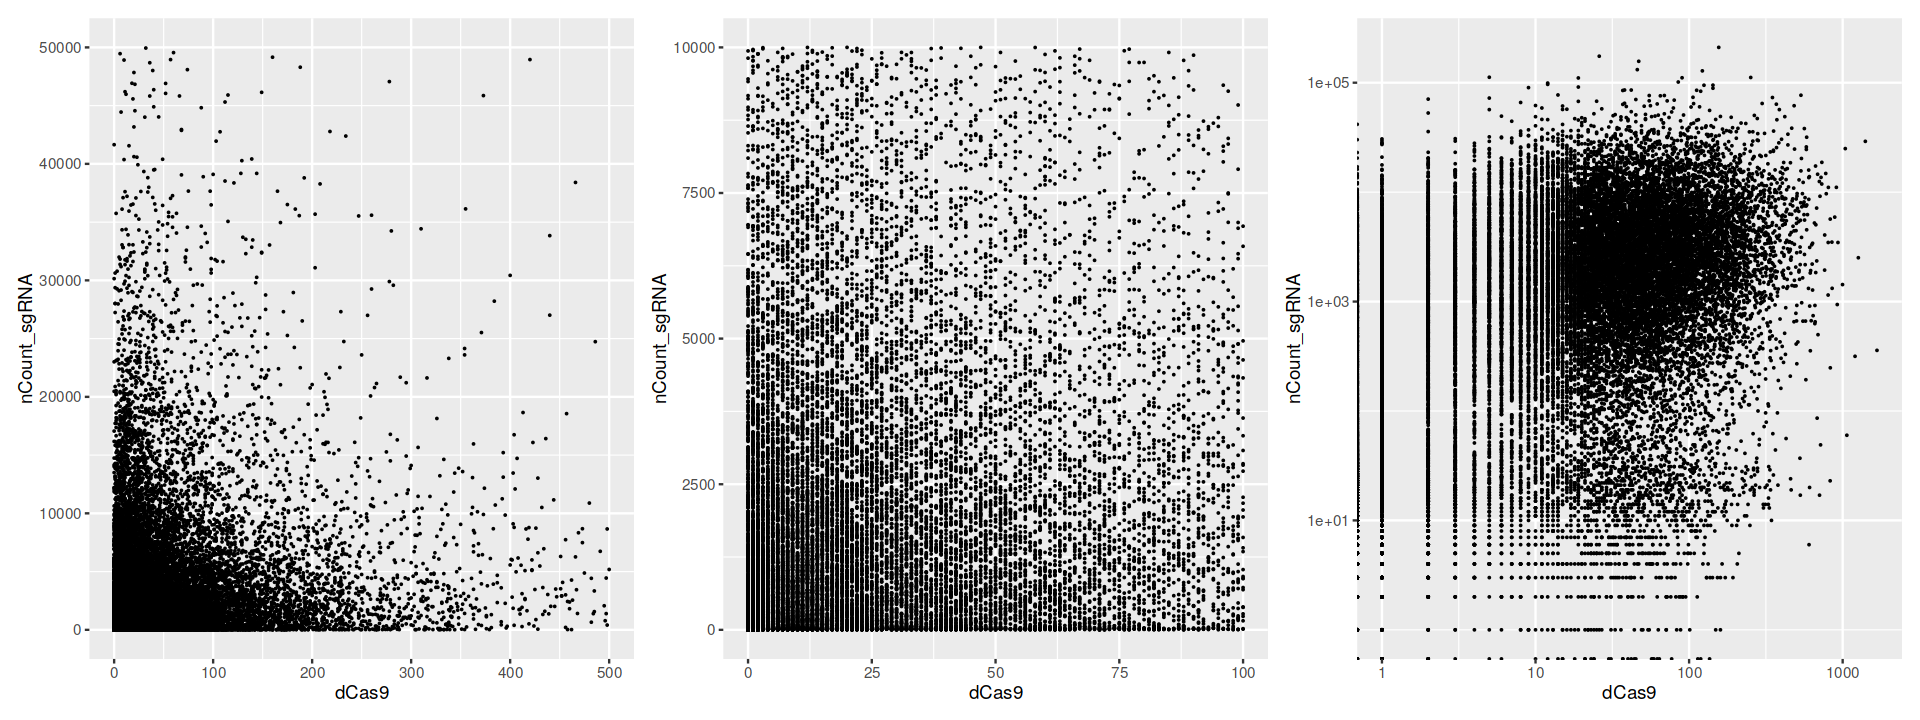

In [49]:
options(repr.plot.width = 16, repr.plot.height = 6)

ggplot(seurat_combined@meta.data, aes(x = dCas9, nCount_sgRNA)) +
    geom_point(size = 0.01) +
    xlim(0, 500) +
    ylim(0, 50000) +
    ggplot(seurat_combined@meta.data, aes(x = dCas9, nCount_sgRNA)) +
    geom_point(size = 0.01) +
    xlim(0, 100) +
    ylim(0, 10000) +
    ggplot(seurat_combined@meta.data, aes(x = dCas9, nCount_sgRNA)) +
    geom_point(size = 0.01) +
    scale_y_log10() +
    scale_x_log10()


In [50]:
cor(seurat$nCount_sgRNA, seurat$dCas9, method = "pearson")
cor(seurat$nCount_sgRNA, seurat$dCas9, method = "spearman")


[1] 0.21

[1] 0.46